## MGMTMFE405-2 Computational Methods in Finance
### Project 9 - Mortgage Backed Security Valuation
### March 13, 2019
### Hyeuk Jung (005259560)

In [1]:
#
# Jung_Hyeuk_Project9.py
# MGMTMFE405-2 Computational Methods in Finance - Project 9
# Hyeuk Jung (005259560)
# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton
#

import random
import time
from numpy import *
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
from scipy import optimize
import sys

#random.seed(123456789)
start = time.time()

Current spot rate:0.078
kappa:0.6
MBS maturity (years):30
Mortage rate (WAC):0.08
Notional value:100000
Volatility:0.12
1.(a). MBS price: 100736.11617946075


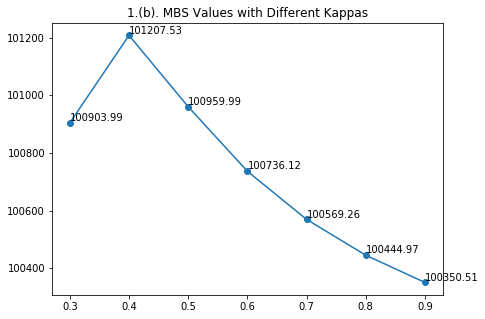

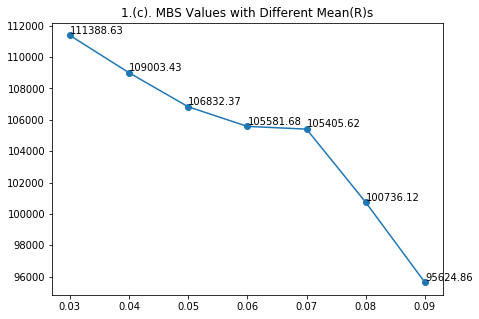

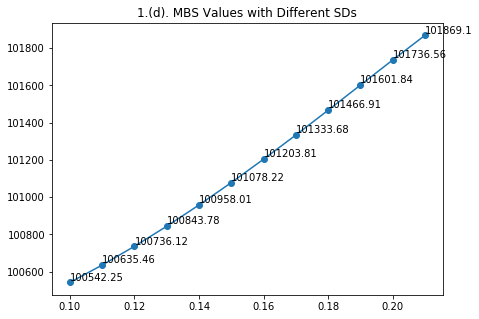

In [2]:
##### Q1. CIR Model -----------------------------------------------------------
def cir_r(r0, sd, t, T, r_bar, kappa, dt, N): 
    # Initialize the seed so that every simulation can have the same process of random numbers
    # ==> Needed for the duration and convexity calculation
    random.seed(123456789)

    # Calculate the steps for the simulation
    T_index = int(T/dt)
    t_index = int(t/dt)
    steps = T_index - t_index

    # Initialize and generate interest rate paths using antithetic variates method
    dW = sqrt(dt)*random.normal(0, 1, int(N/2)*steps).reshape(int(N/2), steps)
    dW = concatenate((dW, -dW), axis=0)

    rates = zeros((N, steps+1))
    rates[:, 0] = r0
    
    # using full truncation method
    for i in range(1, steps+1, 1):
        rates[:, i] = maximum(rates[:, i-1], 0) + kappa*(r_bar - maximum(rates[:, i-1], 0))*dt + sd*sqrt(maximum(rates[:, i-1], 0))*dW[:, i-1]

    return rates 

def treasurybond(r_t, sd, t, T, r_bar, kappa):
    # rt: from CIR result
    # Calculate components of the explicit formula
    h1 = sqrt(kappa*kappa + 2*sd*sd)
    h2 = (kappa + h1) / 2
    h3 = (2*kappa*r_bar) / (sd*sd)

    # A(t, T) and B(t, T) -> 10-year period (T = t+10year or +120months)
    A = ( h1*exp(h2*(T - t)) / (h2*(exp(h1*(T-t)) - 1) + h1) )**h3
    B = (exp(h1*(T - t)) - 1) / (h2*( exp(h1*(T - t)) -1 ) + h1)

    purebond = A*exp(-B*r_t)

    # get annualized 10-yr treasury bond rate using 10-yr treasury bond
    rate = -log(purebond) / 10

    return rate

################################################################
##########                                            ##########
##########          NUMERIX PREPAYMENT NODEL          ##########
##########                                            ##########
################################################################

def refinancingIncentive(wac, treasuryyield_previous_t):
    RI = 0.28 + 0.14*arctan(-8.57+430*(wac - treasuryyield_previous_t))
    return RI

def burnoutEffect(PV_t, PV_0):
    BU = 0.3 + 0.7*PV_t/PV_0
    return BU

def seasonality(month): 
    seasonality = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    index = (month-1) % 12 # month -> 0 = Jan, 1 = Feb, 2 = Mar, ...., 11 = Dec

    return seasonality[index]

def seasoning(t):
    return min(1, t/30)

def conditionalPrepaymentRate(wac, treasuryyield, PV_t, PV_0, t):
    RI = refinancingIncentive(wac, treasuryyield)
    BU = burnoutEffect(PV_t, PV_0)
    SY = seasonality(t)
    SG = seasoning(t)

    CPR_t = RI*BU*SY*SG

    return CPR_t


################################################################
##########                                            ##########
##########                MBS VALUATION               ##########
##########                                            ##########
################################################################

def payment(present_value, r, n, t): # PMT = SP (scheduled principal payment) + Int
    # present_value = pv_t-1
    pmt_t = (present_value*r) / ( 1 - 1/(1+r)**(n-(t-1)) )

    #pmt = sp + int
    # sp = (present_value*r) * ( 1/(1 - (1+r)**(-n+(t-1))) - 1 )
    # int = present_value*r
    return pmt_t

def scheduled_pay(present_value, r, n, t):
    sp_t = (present_value*r) * ( 1/(1 - (1+r)**(-n+(t-1))) - 1 )
    return sp_t

def Prepayment_value(present_value, scheduled_pay, cpr_t):
    # scheduled_pay = sp_t
    pp_t = (present_value - scheduled_pay) * (1 - (1 - cpr_t)**(1/12))
    return pp_t


################################################################
##########                                            ##########
##########                INTEGRATION                 ##########
##########                                            ##########
################################################################

# USER INPUT...?
def MBS(r0, sd, t, T, r_bar, kappa, wac, notional_value, N):
    r = wac/12 # monthly payment rate
    dt = 1/12 # 10-year base -> monthly
    steps = int(T/dt)
    months = int(T*12)
    PV_0 = notional_value

    # 10-yr treasury bond yield: get 10yr treasury bond yield (result: each line of list is array -> combine lines into array )
    rates = cir_r(r0, sd, t, T, r_bar, kappa, dt, N) 
    treasuryyield = array(list(map(lambda r_t: treasurybond(r_t, sd, 0, 10, r_bar, kappa), rates)) )

    # discount factor for cash flows 
    discount_factor = exp(-dt * cumsum(rates, axis = 1))

    ##### CONSIDER PAYMENT STARTS FROM THE FIRST MONTH (NOT AT t = 0)
    cashflows = zeros((N, months)) # 12*30 months -> 360
    PV = zeros((N, months+1)) # including PV_0 -> 361
    PV[:, 0] = notional_value
    for t in arange(1, months, 1):
        # Get conditional prepayment rates(cpr_t), payments(pmt_t), 
        # scheduled principal payments(sp_t), and prepaid principal payments(pp_t)
        cpr_t = conditionalPrepaymentRate(wac, treasuryyield[:, t-1], PV[:, t-1], PV[:, 0], t)
        pmt_t = payment(PV[:, t-1], r, steps, t)
        sp_t = scheduled_pay(PV[:, t-1], r, steps, t)
        pp_t = Prepayment_value(PV[:, t-1], sp_t, cpr_t)

        # update the cash flows and the present value of the MBS
        cashflows[:, t-1] = pmt_t + pp_t # n = steps
        PV[:, t] = PV[:, t-1] - sp_t - pp_t

    mbs = mean(sum(discount_factor[:, :-1] * cashflows, axis = 1))

    return mbs


# Read in user inputs for the simulation
r0 = float(input("Current spot rate:"))
kappa = float(input("kappa:"))
T = float(input("MBS maturity (years):"))
wac = float(input("Mortage rate (WAC):"))
notional_value = float(input("Notional value:"))
sd = float(input("Volatility:"))
t = 0
N = 10000
r_bar = 0.08


# 1. (a).
mbs_value = MBS(r0, sd, t, T, r_bar, kappa, wac, notional_value, N)
print('1.(a). MBS price:', mbs_value)


# NUMERIX-PREPAYMENT model input parameters
# wac = R = annual rate -> divide by 12 to get monthly cash flows
t = 0; T = 30; wac = 0.08; notional_value = 100000 

# CIR model input parameters
r0 = 0.078; kappa = 0.6; r_bar = 0.08; sd = 0.12; N = 10000

# 1. (b).
kappas = arange(0.3, 0.9+0.1, 0.1)
q1b = [ MBS(r0, sd, t, T, r_bar, i, wac, notional_value, N) for i in kappas ]

plt.figure(figsize=(7,5))
plt.plot(kappas, q1b, marker = 'o')
for a, b in zip(kappas, q1b): 
    plt.text(a, b, str(round(b, 2)), ha='left', va='bottom')
plt.title('1.(b). MBS Values with Different Kappas')
plt.show()

# 1. (c).
r_bars = arange(0.03, 0.09+0.01, 0.01)
q1c = [ MBS(r0, sd, t, T, i, kappa, wac, notional_value, N) for i in r_bars ]

plt.figure(figsize=(7,5))
plt.plot(r_bars, q1c, marker = 'o')
for a, b in zip(r_bars, q1c): 
    plt.text(a, b, str(round(b, 2)), ha='left', va='bottom')
plt.title('1.(c). MBS Values with Different Mean(R)s')
plt.show()

# 1. (d).
sds = arange(0.1, 0.2+0.01, 0.01)
q1d = [ MBS(r0, i, t, T, r_bar, kappa, wac, notional_value, N) for i in sds ]

plt.figure(figsize=(7,5))
plt.plot(sds, q1d, marker = 'o')
for a, b in zip(sds, q1d): 
    plt.text(a, b, str(round(b, 2)), ha='left', va='bottom')
plt.title('1.(d). MBS Values with Different SDs')
plt.show()



In [3]:
##### Q2. Option-Adjusted Spread ----------------------------------------------

################################################################
##########                                            ##########
##########           Option-Adjusted Spread           ##########
##########                                            ##########
################################################################

def MBS_OAS(r0, sd, t, T, r_bar, kappa, wac, notional_value, N, OAS):

    # notional_value = PV_0
    r = wac/12 # monthly payment rate
    dt = 1/12 # 10-year base -> monthly
    steps = int(T/dt)
    months = T*12
    PV_0 = notional_value

    # 10-yr treasury bond yield: get 10yr treasury bond yield (result: each line of list is array -> combine lines into array )
    rates = cir_r(r0, sd, t, T, r_bar, kappa, dt, N) 
    treasuryyield = array(list(map(lambda r_t: treasurybond(r_t, sd, 0, 10, r_bar, kappa), rates)) )
    #treasurybond(rt, sd, t, T, r_bar, kappa)

    # discount factor for cash flows 
    discount_factor = exp(-dt * cumsum(rates + OAS, axis = 1))

    ##### CONSIDER PAYMENT STARTS FROM THE FIRST MONTH (NOT AT t = 0!!!)
    PV_t = PV_0 # initializing the value
    cashflows = zeros((N, months)) # month -> 360
    PV = zeros((N, months+1)) # -> 361
    PV[:, 0] = notional_value
    for t in arange(1, months, 1):
        cpr_t = conditionalPrepaymentRate(wac, treasuryyield[:, t-1], PV[:, t-1], PV[:, 0], t)
        pmt_t = payment(PV[:, t-1], r, steps, t)
        sp_t = scheduled_pay(PV[:, t-1], r, steps, t)
        pp_t = Prepayment_value(PV[:, t-1], sp_t, cpr_t)

        cashflows[:, t-1] = pmt_t + pp_t # n = steps
        PV[:, t] = PV[:, t-1] - sp_t - pp_t

    mbs = mean(sum(discount_factor[:, :-1] * cashflows, axis = 1))

    return mbs

def search_OAS(OAS, market_value):
    difference = MBS_OAS(r0=0.078, sd=0.12, t=0, T=30, r_bar=0.08, kappa=0.6, wac=0.08, notional_value=100000, N=10000, OAS=OAS) - market_value
    return difference

market_value = 110000 # market price
# find the OAS value that minimizes the difference
OAS = optimize.newton(func = search_OAS, x0 = 0, args = (market_value, ), tol=1e-10, maxiter=500)
print('2. Option-Adjusted Spread(OAS) for the market price of $110,000:', OAS)



2. Option-Adjusted Spread(OAS) for the market price of $110,000: -0.012625995561660339


In [4]:
##### Q3. OAS-adjusted Duration and Convexity ---------------------------------
bp = 5/100/100 # 5bp
P_0 = MBS_OAS(r0=0.078, sd=0.12, t=0, T=30, r_bar=0.08, kappa=0.6, wac=0.08, notional_value=100000, N=10000, OAS=OAS)
P_down = MBS_OAS(r0=0.078, sd=0.12, t=0, T=30, r_bar=0.08, kappa=0.6, wac=0.08, notional_value=100000, N=10000, OAS=OAS-bp)
P_up = MBS_OAS(r0=0.078, sd=0.12, t=0, T=30, r_bar=0.08, kappa=0.6, wac=0.08, notional_value=100000, N=10000, OAS=OAS+bp)
#print('P_0:', P_0, '\nP_down:', P_down, '\nP_up:', P_up)

oas_duration = (P_down - P_up) / (2*bp*P_0)
oas_convexity = (P_up + P_down - 2*P_0) / (2*P_0*bp*bp)
print('3. OAS-adjusted Duration:', round(oas_duration, 4), '\n   OAS-adjusted Convexity:', round(oas_convexity, 4))

end = time.time() - start
print('Execution time:', end)

3. OAS-adjusted Duration: 7.2079 
   OAS-adjusted Convexity: 45.6532
Execution time: 43.375638008117676
